In [1]:
# pyright: reportUnknownArgumentType=false
from rich.theme import Theme
from rich.console import Console

from finesse.model import Model
from finesse.analysis.actions import (
    TemporaryParameters,
    Change,
    Maximize,
    Minimize,
    Series,
    FrequencyResponse,
    Xaxis,
    Noxaxis,
)
from finesse.solutions import SeriesSolution

from matplotlib.pyplot import figure, show
from matplotlib.axes import Axes

from numpy import geomspace, linspace, sqrt
from science_signal import Signal
from scipy.io.matlab import loadmat

from numpy.typing import NDArray
from typing import Any, NamedTuple, Literal, Callable

from pathlib import Path

In [2]:
from gettext import install
from logging import getLogger

In [3]:
install(__name__)
logger = getLogger(__name__)
theme = Theme(
    {
        "strong": "cyan underline",
        "result": "red bold",
        "error": "red underline bold",
    }
)
console = Console(theme=theme)

In [4]:
C_DARK_FRINGE = 8e-3

/home/demagny/codes/python/finesse/finesse-simulation-04/.venv/lib/python3.13/site-packages/pygraphviz/agraph.py:1403: RuntimeWarning: Warning: Illegal value sgd for attribute "mode" in graph  - ignored

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


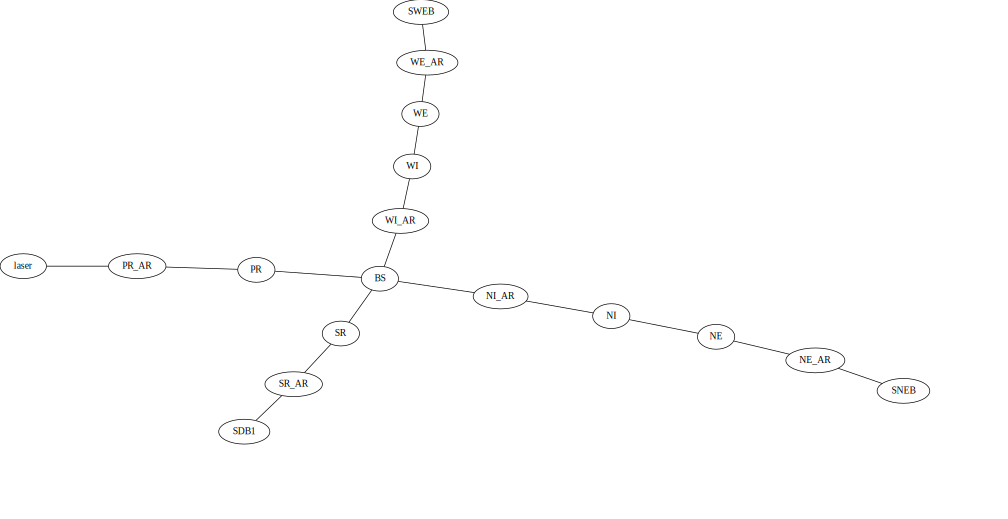

In [5]:
%matplotlib ipympl
model_file = Path("model.kat")
model = Model()
model.phase_config(zero_k00=False, zero_tem00_gouy=True)
model.modes(modes="off")  # pyright: ignore[reportUnusedCallResult]
model.parse(model_file.read_text())
model.lambda0 = model.get("wavelength")
model.plot_graph()  # pyright: ignore[reportUnusedCallResult]
show()

In [6]:
result = model.run(
    TemporaryParameters(
        Series(
            Change(
                {
                    "SR.misaligned": True,
                    "PR.misaligned": True,
                }
            ),
            Maximize(
                model.get("NE_p1"),
                model.get("NORTH_ARM.DC"),
                bounds=[-180, 180],
                tol=1e-14,
            ),
            Maximize(
                model.get("WE_p1"),
                model.get("WEST_ARM.DC"),
                bounds=[-180, 180],
                tol=1e-14,
            ),
            Minimize(
                model.get("SR_p2"), model.get("MICH.DC"), bounds=[-180, 180], tol=1e-14
            ),
            Change(
                {
                    "PR.misaligned": False,
                }
            ),
            Maximize(
                model.get("PR_p2"), model.get("PRCL.DC"), bounds=[-180, 180], tol=1e-14
            ),
            Change(
                {
                    "SR.misaligned": False,
                }
            ),
            Maximize(
                model.get("B1_DC"), model.get("SRCL.DC"), bounds=[-180, 180], tol=1e-14
            ),
            Change(
                {
                    "SRCL.DC": -90,
                },
                relative=True,
            ),
        ),
        exclude=[
            "NE.phi",
            "NI.phi",
            "WE.phi",
            "WI.phi",
            "SR.phi",
            "PR.phi",
            "NORTH_ARM.DC",
            "WEST_ARM.DC",
            "DARM.DC",
            "MICH.DC",
            "PRCL.DC",
            "SRCL.DC",
            "SR.misaligned",
        ],
    ),
)
model._settings.phase_config.zero_k00 = False
model.fsig.f = 1

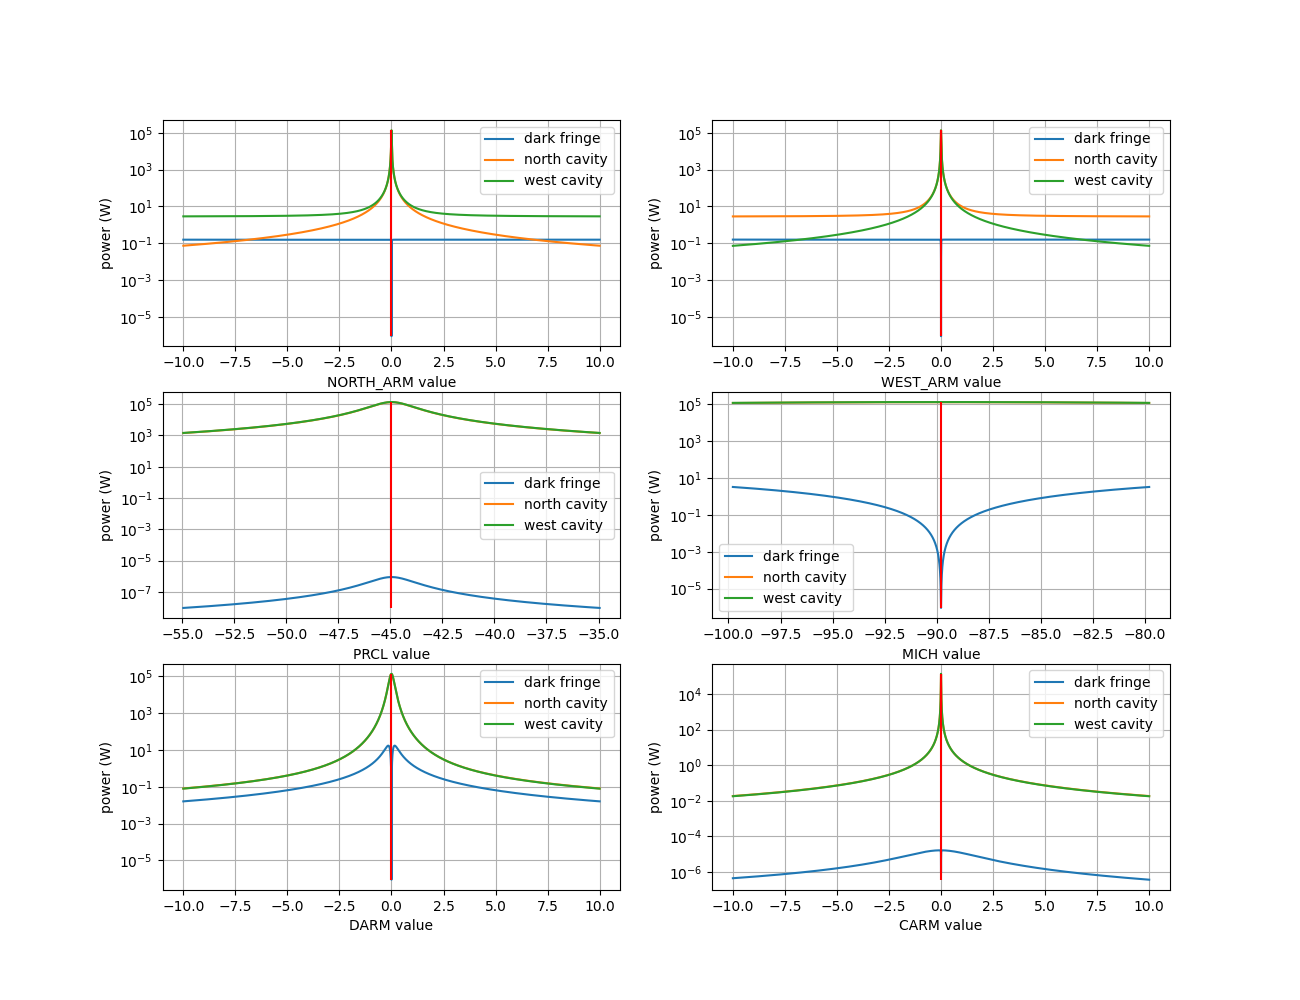

Degré de liberté 0.00164794921875 trouvé en 14 pas pour avoir une puissance de 0.007914176860517742 W sur B1

In [7]:
def compute_solutions(
    model: Model, DOF: str, padding: float, nb: int = 10000
) -> SeriesSolution:
    return model.run(
        Xaxis(
            model.get(DOF).DC,
            "lin",
            model.get(DOF).DC - padding,
            model.get(DOF).DC + padding,
            nb,
        )
    )


def display_ax(
    ax: Axes,
    solution: SeriesSolution,
    model: Model,
    DOF: str,
    padding: float,
    nb: int = 10000,
) -> Axes:
    x = linspace(model.get(DOF).DC - padding, model.get(DOF).DC + padding, nb + 1)
    _ = ax.semilogy(x, solution["SR_p2"], label="dark fringe")
    _ = ax.semilogy(x, solution["NE_p1"], label="north cavity")
    _ = ax.semilogy(x, solution["WE_p1"], label="west cavity")
    _ = ax.vlines(
        [model.get(DOF).DC],
        min(solution["SR_p2"]),
        max(solution["NE_p1"]),
        colors="red",
    )
    _ = ax.set_ylabel("power (W)")
    ax.grid()
    _ = ax.legend()
    return ax


class DisplayData(NamedTuple):
    DOF: str
    padding: float


data: list[DisplayData] = [
    DisplayData("NORTH_ARM", 10),
    DisplayData("WEST_ARM", 10),
    DisplayData("PRCL", 10),
    DisplayData("MICH", 10),
    DisplayData("DARM", 10),
    DisplayData("CARM", 10),
]

Figure = figure(figsize=(13, 10))
nb = int(1e4)

for i in range(len(data)):
    element: DisplayData = data[i]
    ax = Figure.add_subplot(3, 2, i + 1)
    solution = compute_solutions(model, element.DOF, element.padding, nb)
    _ = display_ax(ax, solution, model, element.DOF, element.padding, nb).set_xlabel(
        "{} value".format(element.DOF)
    )
show()

solution = model.run(Noxaxis())
result = solution["B1_DC"]
start, stop, nb = 0, 1, 0
while (abs(result - C_DARK_FRINGE) > 1e-4) and (nb < 100):
    nb += 1
    temp = start + (stop - start) / 2

    model.DARM.DC = temp
    solution = model.run(Noxaxis())
    result = solution["B1_DC"]
    if result > C_DARK_FRINGE:
        stop = temp
    else:
        start = temp
console.print(
    "Degré de liberté [result]{dof}[/result] trouvé en [strong]{nb} pas[/strong] pour avoir une puissance de [result]{result} W[/result] sur B1".format(
        nb=nb, dof=model.DARM.DC, result=result
    )
)

In [8]:
def show_evolution(
    parameter: str,
    model: Model,
    values: NDArray[Any],
    TFs: list[str],
    phase: int | float = 45,
):
    power_detector = "B1.I"
    model = model.deepcopy()
    model.SNEB.phi = model.NE.phi - phase
    model.SWEB.phi = model.WE.phi - phase
    model.SDB1.phi = model.SR.phi + phase

    if len(TFs) == 0:
        console.print("[error]Nothing to show[/error]")

    Figure = figure(figsize=(7, 5 * len(TFs)))
    Figure.suptitle("TF in function of {}".format(parameter))

    for i in range(len(TFs)):
        _ = Figure.add_subplot(len(TFs), 1, i + 1)

    temp_value = model.get(parameter).eval()
    for value in values:
        index = 0
        model.set(parameter, value)

        DARM = model.run(
            FrequencyResponse(geomspace(5, 10000, 1000), ["DARM"], [power_detector])
        )
        for bench in ["SNEB", "SWEB", "SDB1"]:
            if bench in TFs:
                result = model.run(
                    FrequencyResponse(
                        geomspace(5, 10000, 1000),
                        ["{}_z".format(bench)],
                        [power_detector],
                    )
                )
                _ = Figure.get_axes()[index].set_title(bench)
                _ = Figure.get_axes()[index].loglog(
                    result.f,
                    abs(result[power_detector, "{}_z".format(bench)])
                    / abs(DARM[power_detector, "DARM"])
                    / model.space_NI_NE.L.eval(),
                    label="{} = {:.2E}".format(parameter, value),
                )
                _ = Figure.get_axes()[index].set_xlabel("Frequencies (Hz)")
                _ = Figure.get_axes()[index].set_ylabel("$\\frac{ m } { m }$")
                if phase == 45:
                    _ = Figure.get_axes()[index].set_title("{} $K_P$".format(bench))
                else:
                    _ = Figure.get_axes()[index].set_title("{} $K_n$".format(bench))

                index += 1
    for i in range(len(TFs)):
        _ = Figure.get_axes()[i].grid(True, "both", "both")
        _ = Figure.get_axes()[i].legend()
    show()
    model.set(parameter, temp_value)

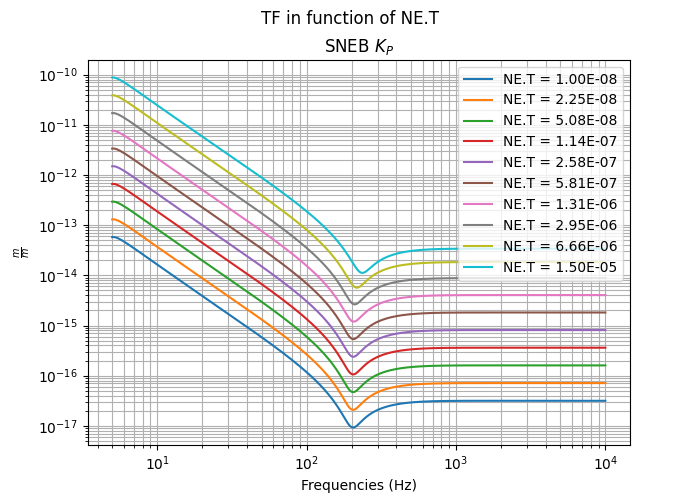

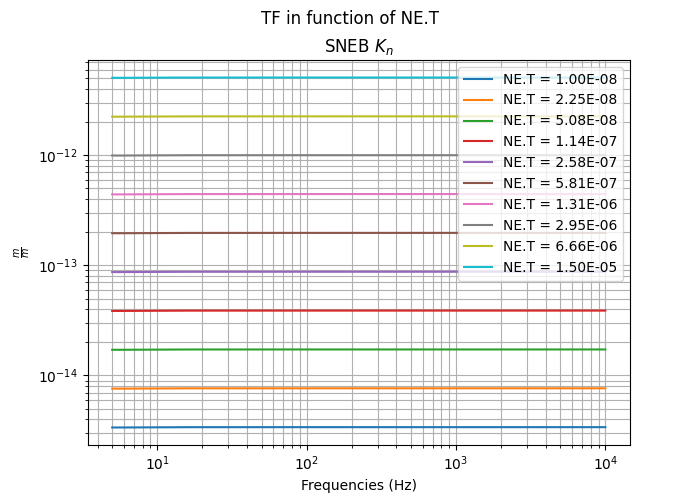

In [9]:
show_evolution("NE.T", model, geomspace(1e-8, 1.5e-5, 10), ["SNEB"])
show_evolution("NE.T", model, geomspace(1e-8, 1.5e-5, 10), ["SNEB"], 0)

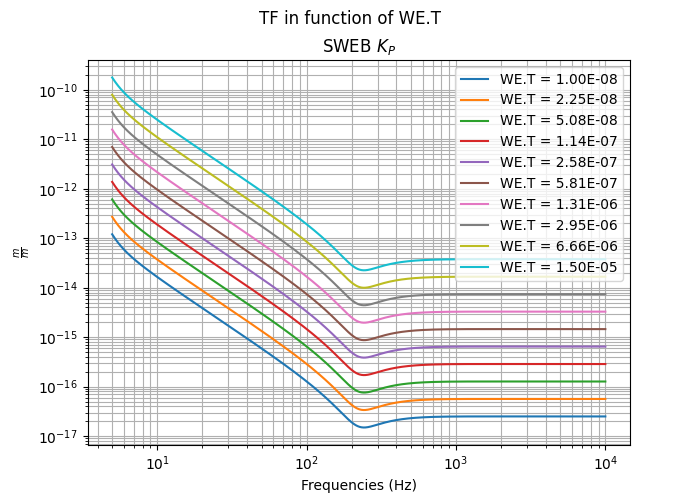

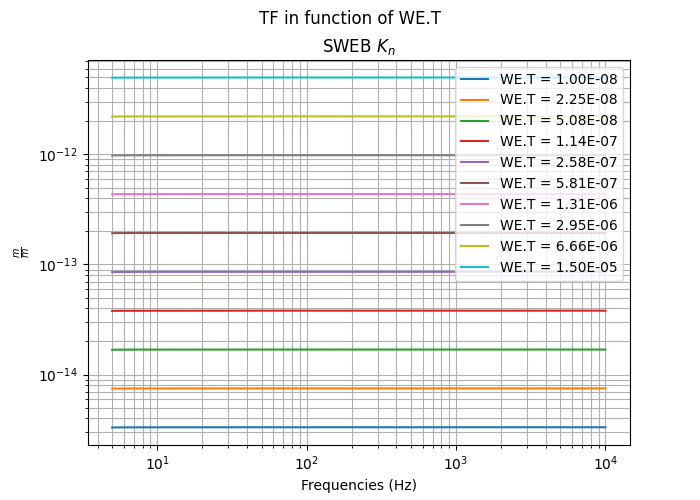

In [10]:
show_evolution("WE.T", model, geomspace(1e-8, 1.5e-5, 10), ["SWEB"])
show_evolution("WE.T", model, geomspace(1e-8, 1.5e-5, 10), ["SWEB"], 0)

In [11]:
# show_evolution("SR.T", model, linspace(0.30, 0.50, 10), ["SDB1"])

In [12]:
# show_evolution("NI.T", model, linspace(1.35e-2, 1.39e-2, 10), ["SNEB", "SWEB", "SDB1"])

In [13]:
# show_evolution("WI.T", model, linspace(1.35e-2, 1.39e-2, 10), ["SNEB", "SWEB", "SDB1"])

In [14]:
def compare_TF(
    model: Model,
    bench: str,
    phase: Literal[45] | Literal[0],
) -> tuple[Signal, Signal, Signal]:
    power_detector = "B1.I"
    model = model.deepcopy()
    model.SNEB.phi = model.NE.phi - phase
    model.SWEB.phi = model.WE.phi - phase
    model.SDB1.phi = model.SR.phi + phase

    modelisation_data = loadmat(Path("optickle.mat"))

    DARM = model.run(
        FrequencyResponse(geomspace(5, 10000, 1000), ["DARM"], [power_detector]),
    )
    TF = model.run(
        FrequencyResponse(
            geomspace(5, 10000, 1000), ["{}_z".format(bench)], [power_detector]
        ),
    )

    TF_finesse = Signal(
        TF.f,
        abs(TF[power_detector, "{}_z".format(bench)])
        / abs(DARM[power_detector, "DARM"])
        / model.space_NI_NE.L,
    )
    TF_optickle = Signal(
        modelisation_data["freq"][0],
        abs(modelisation_data["{}coupling".format(bench)][int(phase / 45)]),  # 1 or 0
    )
    return abs(TF_finesse - TF_optickle)/(abs(TF_finesse) + abs(TF_optickle)), TF_finesse, TF_optickle

In [15]:
def compare_allTF(
    model: Model,
    bench: str,
) -> tuple[Signal, Signal, Signal]:
    power_detector = "B1.I"
    model = model.deepcopy()
    model.SNEB.phi = model.NE.phi - 0
    model.SWEB.phi = model.WE.phi - 0
    model.SDB1.phi = model.SR.phi + 0

    modelisation_data = loadmat(Path("optickle.mat"))

    in_DARM = model.run(
        FrequencyResponse(geomspace(5, 10000, 1000), ["DARM"], [power_detector]),
    )
    in_TF = model.run(
        FrequencyResponse(
            geomspace(5, 10000, 1000), ["{}_z".format(bench)], [power_detector]
        ),
    )
    model.SNEB.phi = model.NE.phi - 45
    model.SWEB.phi = model.WE.phi - 45
    model.SDB1.phi = model.SR.phi + 45

    quad_DARM = model.run(
        FrequencyResponse(geomspace(5, 10000, 1000), ["DARM"], [power_detector]),
    )
    quad_TF = model.run(
        FrequencyResponse(
            geomspace(5, 10000, 1000), ["{}_z".format(bench)], [power_detector]
        ),
    )

    TF_finesse = Signal(
        in_TF.f,
        sqrt((abs(in_TF[power_detector, "{}_z".format(bench)])
        / abs(in_DARM[power_detector, "DARM"])
        / model.space_NI_NE.L)**2 + (abs(quad_TF[power_detector, "{}_z".format(bench)])
        / abs(quad_DARM[power_detector, "DARM"])
        / model.space_NI_NE.L)**2),
    )
    TF_optickle = Signal(
        modelisation_data["freq"][0],
        sqrt(abs(modelisation_data["{}coupling".format(bench)][0]**2 + modelisation_data["{}coupling".format(bench)][1]**2)),
    )
    return abs(TF_finesse - TF_optickle)/(abs(TF_finesse) + abs(TF_optickle)), TF_finesse, TF_optickle

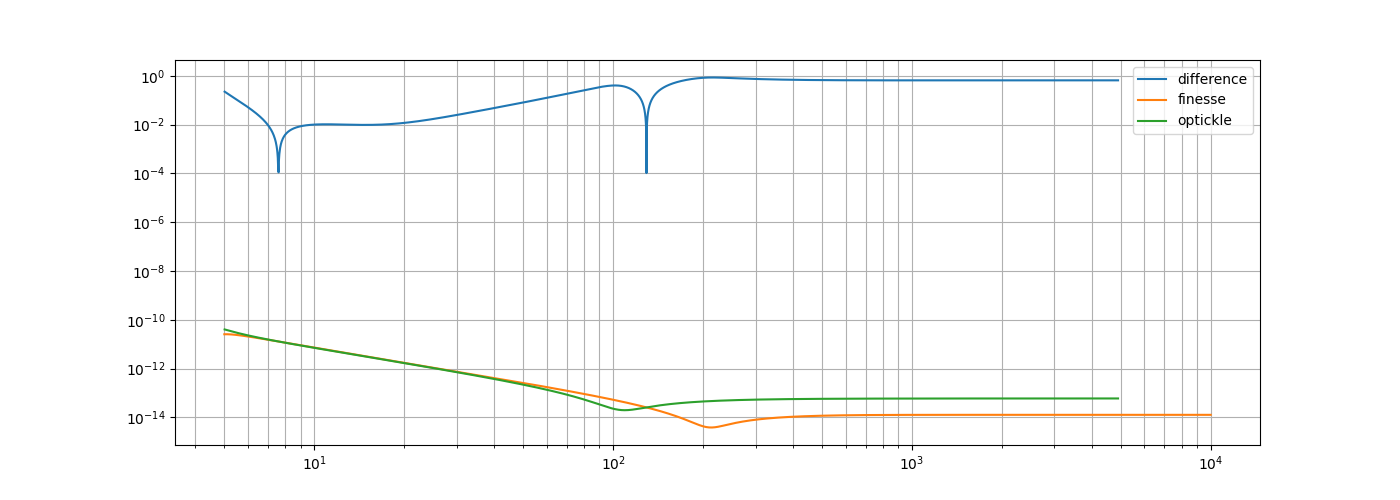

In [16]:
Figure = figure(figsize = (14, 5))
result, TF_finesse, TF_optickle = compare_TF(model, "SNEB", 45)
_ = Figure.gca().loglog(result.x, result.y, label = "difference")
_ = Figure.gca().loglog(TF_finesse.x, TF_finesse.y, label = "finesse")
_ = Figure.gca().loglog(TF_optickle.x, TF_optickle.y, label = "optickle")
_ = Figure.gca().legend()
Figure.gca().grid(True, "both", "both")
show()

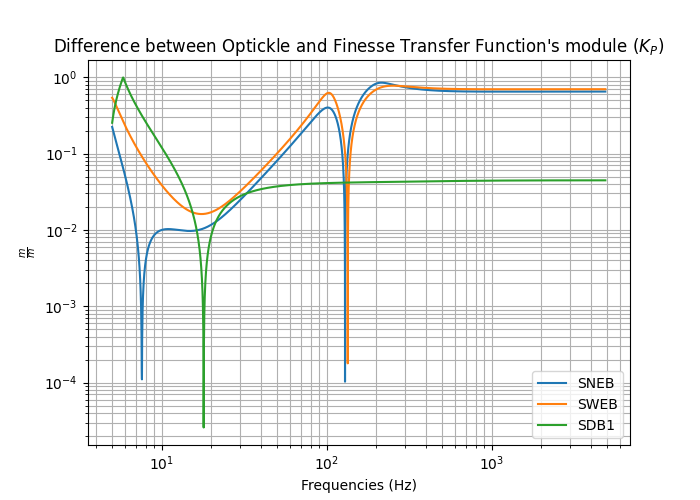

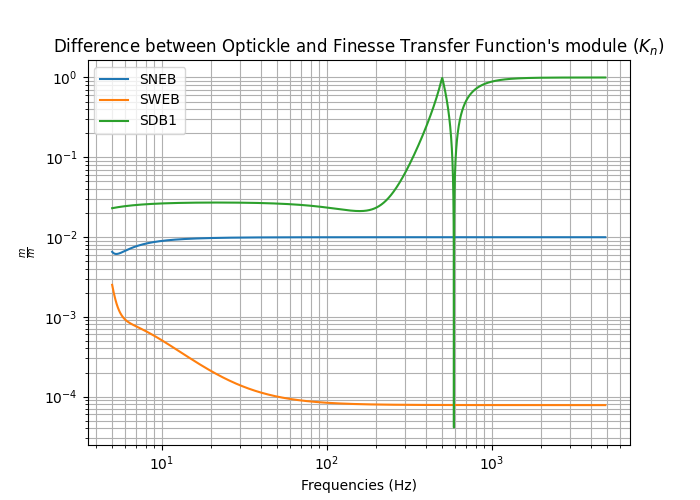

In [17]:
Figure = figure(figsize=(7, 5))
result, _, _ = compare_TF(model, "SNEB", 45)
_ = Figure.gca().loglog(result.x, result.y, label="SNEB")
result, _, _ = compare_TF(model, "SWEB", 45)
_ = Figure.gca().loglog(result.x, result.y, label="SWEB")
result, _, _ = compare_TF(model, "SDB1", 45)
_ = Figure.gca().loglog(result.x, result.y, label="SDB1")
_ = Figure.gca().legend()
_ = Figure.gca().set_title("Difference between Optickle and Finesse Transfer Function's module ($K_P$)")
_ = Figure.gca().set_xlabel("Frequencies (Hz)")
_ = Figure.gca().set_ylabel("$\\frac { m } { m }$")
Figure.gca().grid(True, "both", "both")
show()
Figure = figure(figsize=(7, 5))
result, _, _ = compare_TF(model, "SNEB", 0)
_ = Figure.gca().loglog(result.x, result.y, label="SNEB")
result, _, _ = compare_TF(model, "SWEB", 0)
_ = Figure.gca().loglog(result.x, result.y, label="SWEB")
result, _, _ = compare_TF(model, "SDB1", 0)
_ = Figure.gca().loglog(result.x, result.y, label="SDB1")
_ = Figure.gca().legend()
_ = Figure.gca().set_title("Difference between Optickle and Finesse Transfer Function's module ($K_n$)")
_ = Figure.gca().set_xlabel("Frequencies (Hz)")
_ = Figure.gca().set_ylabel("$\\frac { m } { m }$")
Figure.gca().grid(True, "both", "both")
show()

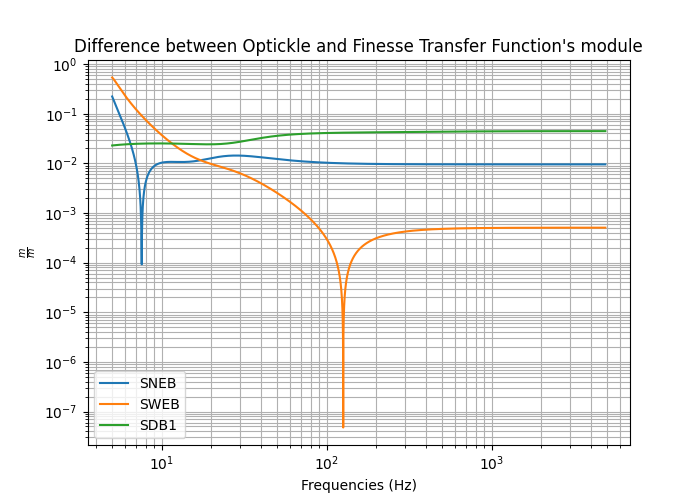

In [18]:
Figure = figure(figsize=(7, 5))
result, _, _ = compare_allTF(model, "SNEB")
_ = Figure.gca().loglog(result.x, result.y, label="SNEB")
result, _, _ = compare_allTF(model, "SWEB")
_ = Figure.gca().loglog(result.x, result.y, label="SWEB")
result, _, _ = compare_allTF(model, "SDB1")
_ = Figure.gca().loglog(result.x, result.y, label="SDB1")
_ = Figure.gca().legend()
_ = Figure.gca().set_title("Difference between Optickle and Finesse Transfer Function's module")
_ = Figure.gca().set_xlabel("Frequencies (Hz)")
_ = Figure.gca().set_ylabel("$\\frac { m } { m }$")
Figure.gca().grid(True, "both", "both")
show()

In [19]:
def change_parameter(
    parameter: str,
    model: Model,
    values: NDArray[Any],
    func: Callable[Any, Signal],
    args: list[Any],
) -> list[Signal]:
    list_result = []
    model = model.deepcopy()
    for value in values:
        model.set(parameter, value)
        list_result.append(func(model, *args))
    return list_result

0.01377

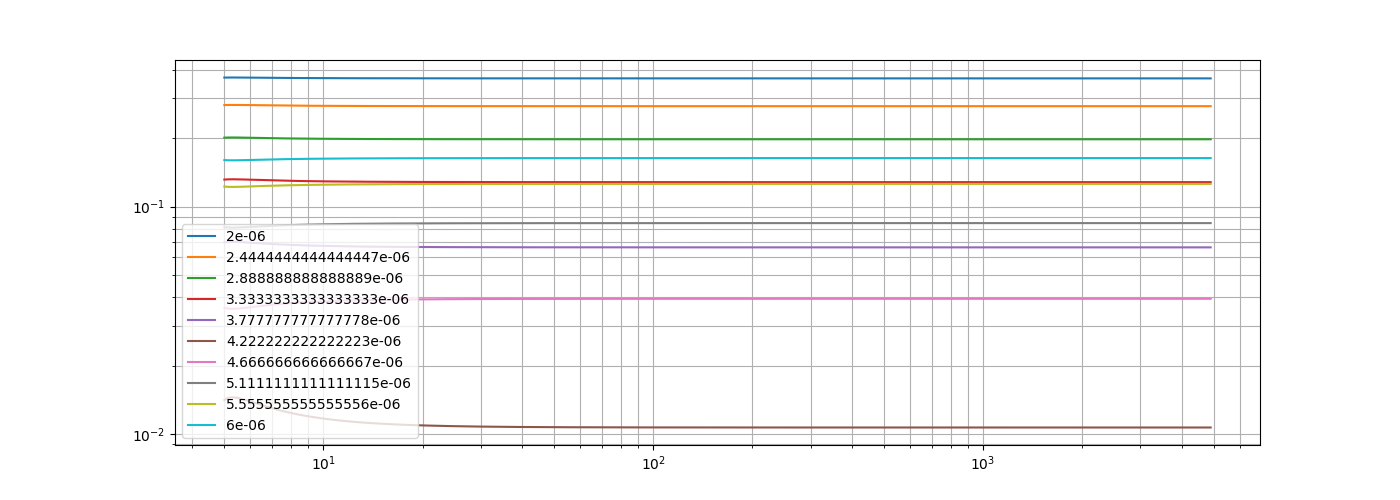

In [20]:
x = linspace(2e-6, 6e-6, 10)
SDB1_quad = change_parameter("NE.T", model, x, compare_TF, ["SNEB", 0])
console.print(model.NI.T)
Figure = figure(figsize=(14, 5))
for i in range(len(x)):
    _ = Figure.gca().loglog(SDB1_quad[i][0].x, SDB1_quad[i][0].y, label = "{}".format(x[i]))
_ = Figure.gca().legend()
Figure.gca().grid(True, "both", "both")
show()

4.3e-06

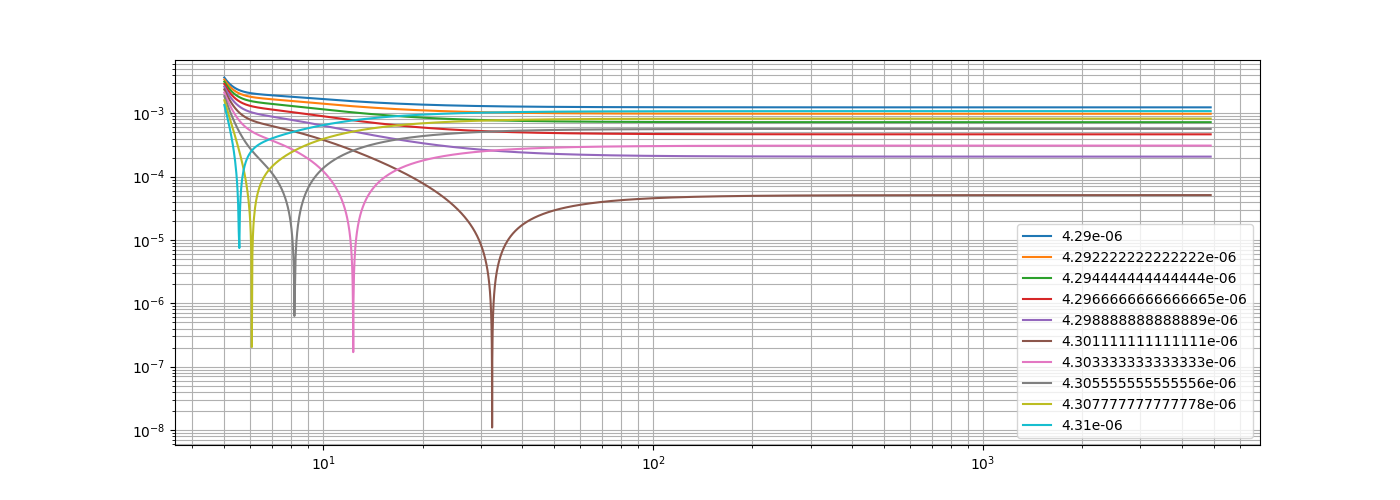

In [21]:
x = linspace(4.29e-6, 4.31e-6, 10)
SDB1_quad = change_parameter("WE.T", model, x, compare_TF, ["SWEB", 0])
console.print(model.WE.T)
Figure = figure(figsize=(14, 5))
for i in range(len(x)):
    _ = Figure.gca().loglog(SDB1_quad[i][0].x, SDB1_quad[i][0].y, label = "{}".format(x[i]))
_ = Figure.gca().legend()
Figure.gca().grid(True, "both", "both")
show()

In [22]:
console.log(model.NE.T)
console.log(model.WE.T)

[11:55:01] 4.4e-06                                                                                   ]8;id=973669;file:///tmp/ipykernel_31537/175181389.py\175181389.py]8;;\:]8;id=755110;file:///tmp/ipykernel_31537/175181389.py#1\1]8;;\

           4.3e-06                                                                                   ]8;id=644398;file:///tmp/ipykernel_31537/175181389.py\175181389.py]8;;\:]8;id=613354;file:///tmp/ipykernel_31537/175181389.py#2\2]8;;\